<a href="https://colab.research.google.com/github/ililililililililililililililil/INI/blob/ini_pytorch/ini_9_4_Batch_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Gradient Vanishing: 그래디언트가 점점 작아지는 문제
#Gradient Exploding: 미분을 할 때 너무 큰 값 or NAN 값이 나오는 문제
#-> 학습이 어려워진다

#간접 해결 방법
#activation function 변경(Lelu)
#초기화를 잘하자
#작은 learning rate 사용

#직졉 해결 방법: Batch Normalization

#Internal Covariate Shift
#Covariate Shift: 트레이닝 셋과 테스트 셋에는 차이가 있다
#Internal Covariate Shift: 학습 하면서 레이어를 통과하는 과정에서 분포가 변한다.
#(레이어끼리 입출력 차이 문제)
#-> 해결: Batch Normalization

#Batch Normalization
#각 레이어마다 변형된 분포가 나오지 않도록 Normalization한다.

In [2]:
# Lab 10 MNIST and softmax
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pylab as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

In [4]:
# parameters
learning_rate = 0.01
training_epochs = 10
batch_size = 32

In [5]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 130063916.35it/s]


Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 60446953.01it/s]


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35218675.95it/s]


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10542627.98it/s]


Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [6]:
# dataset loader
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

In [7]:
# nn layers
#Batch Normalization을 사용하는 모델
linear1 = torch.nn.Linear(784, 32, bias=True)
linear2 = torch.nn.Linear(32, 32, bias=True)
linear3 = torch.nn.Linear(32, 10, bias=True)
relu = torch.nn.ReLU()
bn1 = torch.nn.BatchNorm1d(32)
bn2 = torch.nn.BatchNorm1d(32)

#Batch Normalization을 사용하지 않는 모델
nn_linear1 = torch.nn.Linear(784, 32, bias=True)
nn_linear2 = torch.nn.Linear(32, 32, bias=True)
nn_linear3 = torch.nn.Linear(32, 10, bias=True)

In [8]:
# model
bn_model = torch.nn.Sequential(linear1, bn1, relu,
                            linear2, bn2, relu,
                            linear3).to(device)
nn_model = torch.nn.Sequential(nn_linear1, relu,
                               nn_linear2, relu,
                               nn_linear3).to(device)

In [9]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

In [10]:
# Save Losses and Accuracies every epoch
# We are going to plot them later
train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

train_total_batch = len(train_loader)
test_total_batch = len(test_loader)
for epoch in range(training_epochs):
    bn_model.train()  # set the model to train mode

    for X, Y in train_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        bn_optimizer.zero_grad()
        bn_prediction = bn_model(X)
        bn_loss = criterion(bn_prediction, Y)
        bn_loss.backward()
        bn_optimizer.step()

        nn_optimizer.zero_grad()
        nn_prediction = nn_model(X)
        nn_loss = criterion(nn_prediction, Y)
        nn_loss.backward()
        nn_optimizer.step()

    with torch.no_grad():
        bn_model.eval()     # set the model to evaluation mode

        # Test the model using train sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(train_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / train_total_batch, nn_loss / train_total_batch, bn_acc / train_total_batch, nn_acc / train_total_batch

        # Save train losses/acc
        train_losses.append([bn_loss, nn_loss])
        train_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-TRAIN] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
            (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        # Test the model using test sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(test_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / test_total_batch, nn_loss / test_total_batch, bn_acc / test_total_batch, nn_acc / test_total_batch

        # Save valid losses/acc
        valid_losses.append([bn_loss, nn_loss])
        valid_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-VALID] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
                (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        print()

print('Learning finished')

[Epoch 1-TRAIN] Batchnorm Loss(Acc): bn_loss:0.13576(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.18107(nn_acc:0.94)
[Epoch 1-VALID] Batchnorm Loss(Acc): bn_loss:0.14904(bn_acc:0.95) vs No Batchnorm Loss(Acc): nn_loss:0.19708(nn_acc:0.94)

[Epoch 2-TRAIN] Batchnorm Loss(Acc): bn_loss:0.10362(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.19521(nn_acc:0.94)
[Epoch 2-VALID] Batchnorm Loss(Acc): bn_loss:0.12712(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.22109(nn_acc:0.93)

[Epoch 3-TRAIN] Batchnorm Loss(Acc): bn_loss:0.09017(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.13247(nn_acc:0.96)
[Epoch 3-VALID] Batchnorm Loss(Acc): bn_loss:0.11477(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.16779(nn_acc:0.96)

[Epoch 4-TRAIN] Batchnorm Loss(Acc): bn_loss:0.07048(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.12778(nn_acc:0.96)
[Epoch 4-VALID] Batchnorm Loss(Acc): bn_loss:0.10020(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.17270(nn_acc:0.95)

[Epoch 5-TRAIN] Batc

In [11]:
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]

    plt.figure(figsize=(15, 10))
    plt.plot(bn, label='With BN')
    plt.plot(nn, label='Without BN')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

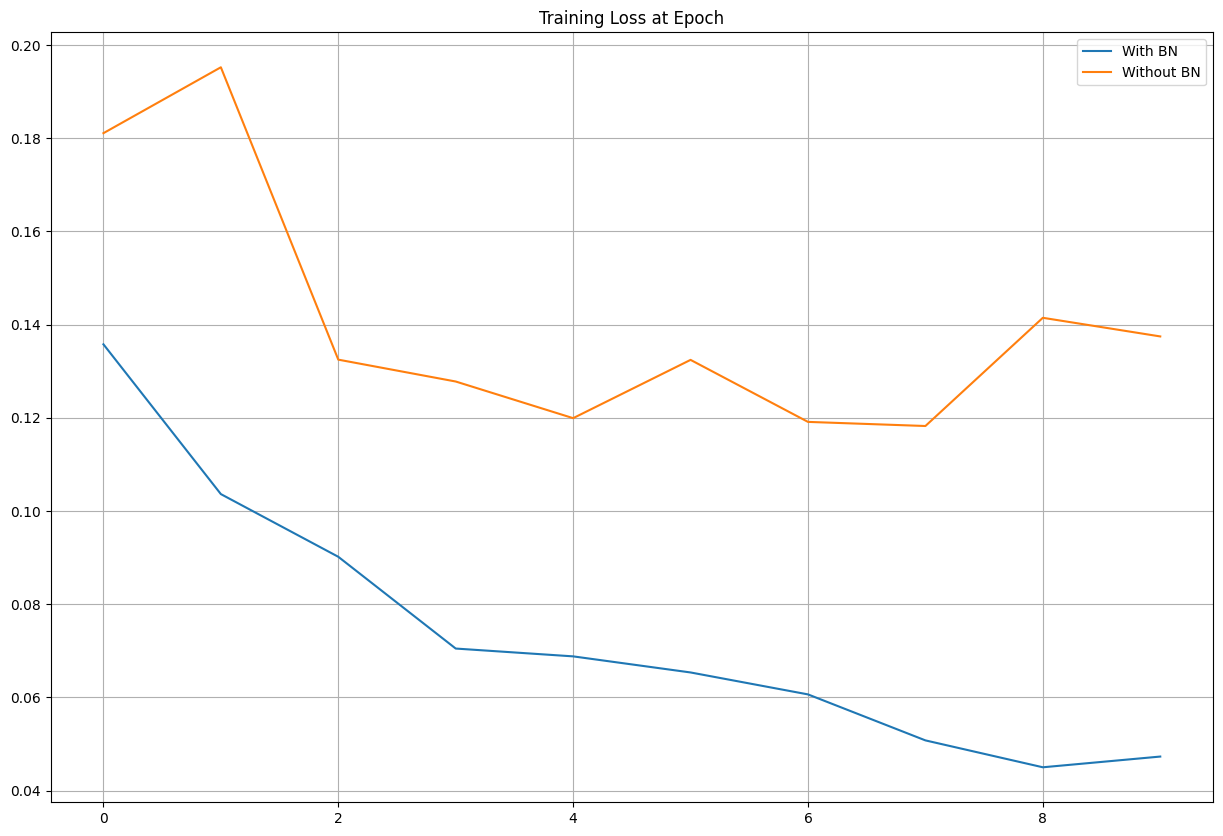

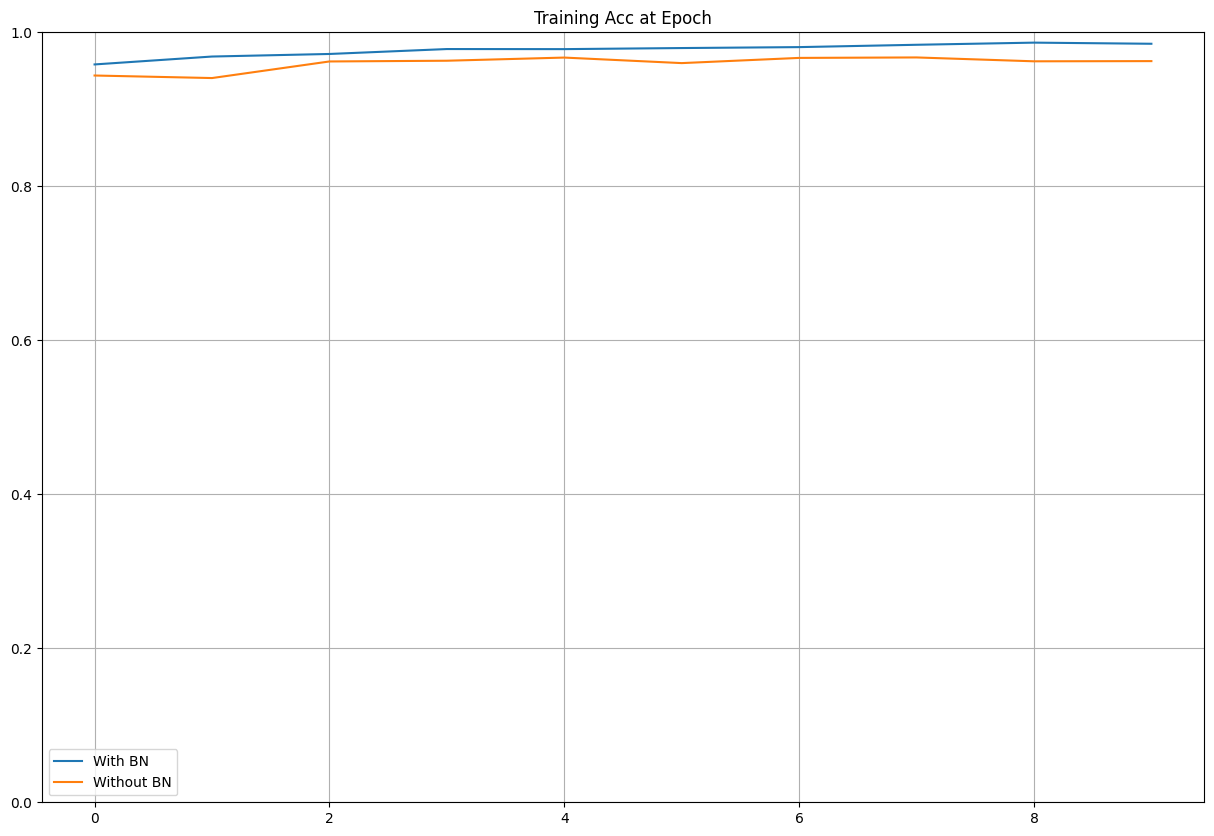

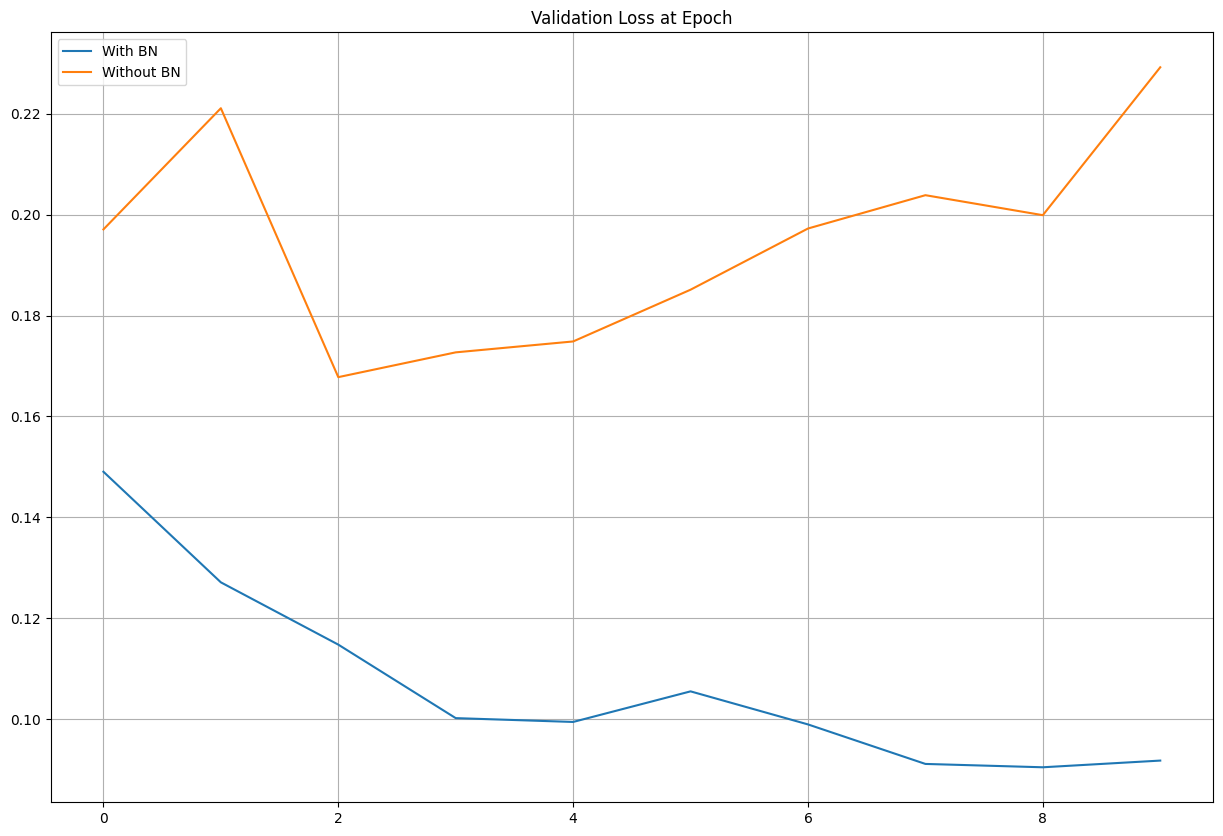

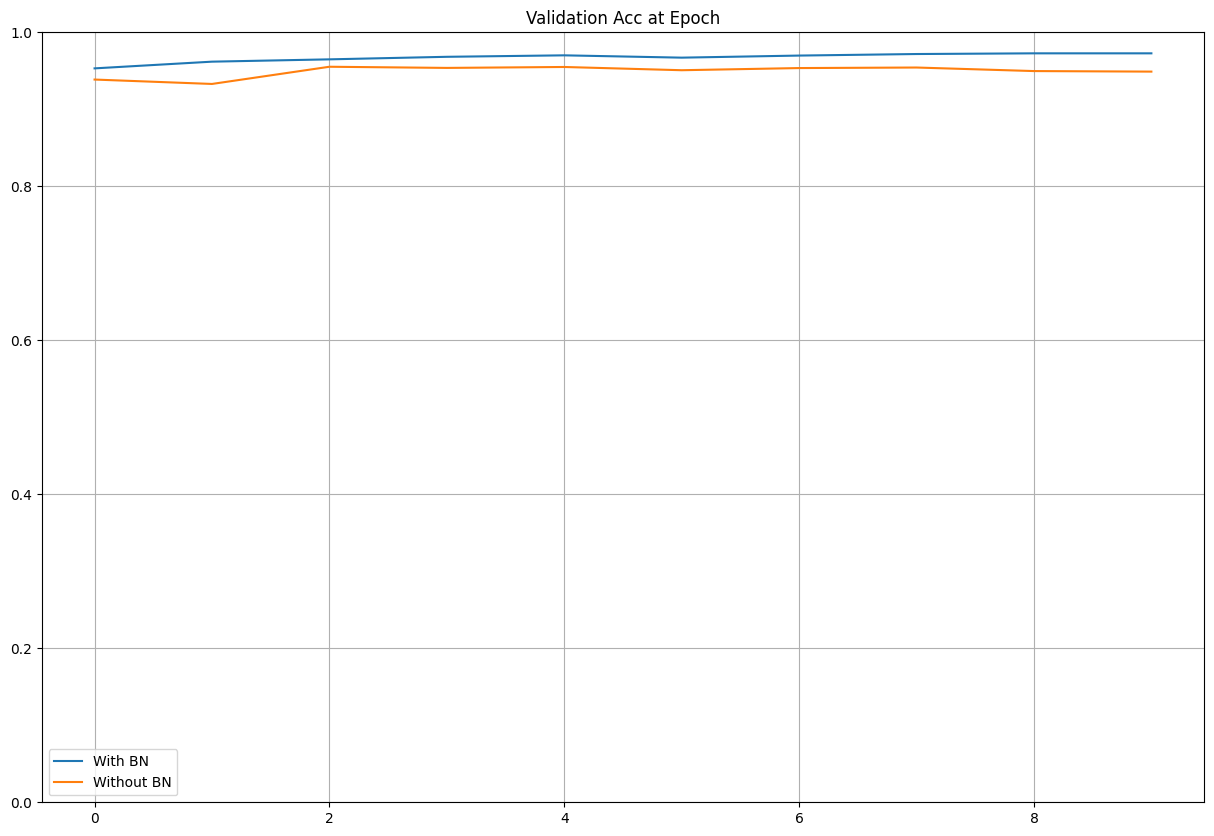

In [12]:
plot_compare(train_losses, title='Training Loss at Epoch')
plot_compare(train_accs, [0, 1.0], title='Training Acc at Epoch')
plot_compare(valid_losses, title='Validation Loss at Epoch')
plot_compare(valid_accs, [0, 1.0], title='Validation Acc at Epoch')

In [13]:
#Batch Normalization을 사용할 때 더 학습을 잘한다(Loss가 적다)